[View in Colaboratory](https://colab.research.google.com/github/daphnei/weakvideo/blob/master/visualize_faces.ipynb)

In [2]:
#@title Run this to clone the repo.
! git clone https://github.com/daphnei/weakvideo.git


Cloning into 'weakvideo'...
remote: Counting objects: 322, done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 322 (delta 30), reused 26 (delta 14), pack-reused 254
Receiving objects: 100% (322/322), 216.01 MiB | 25.64 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [0]:
#@title Run this to pull from the repo.
! cd weakvideo; git pull

In [0]:
#@title Python imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
import scipy.ndimage
import skimage.color
import random

sys.path.append(os.path.abspath(os.path.join('weakvideo/code')))

import utils
import visualization as vis

In [0]:
#@title Modify this code section to change the episode.
episode=7

# Need to update the paths in here too:
!wget www.seas.upenn.edu/~daphnei/images/ep7/face_data.pkl .
!wget www.seas.upenn.edu/~daphnei/GoT/Character_count_episode7.csv
!wget www.seas.upenn.edu/~daphnei/GoT/CUTS_episode7.csv

charactersFile = 'Character_count_episode%d.csv' % (episode)
cutsFile = 'CUTS_episode%d.csv' % (episode)

In [0]:
facesDict = utils.pickleToFaces('face_data.pkl')
allFaces = []
for cut in facesDict.keys():
  allFaces.extend(facesDict[cut])
  
tweet_stream_offsets = [2.43333, 1.23333, 1.45000, 1.41667, 1.43333, 1.55000, 1.53333]
offset = tweet_stream_offsets[episode-1]

charactersForEp = utils.processCharactersFile(charactersFile, offset)
cutsForEp = utils.readCuts(cutsFile)

In [0]:
sns.set_style("whitegrid", {'axes.grid' : False})


In [0]:
#@title Helper function to display faces using matplotlib.
def showFaces(faces):
  if len(faces) == 0:
    print('No faces to visualize.')
  numFacesPerRow = 15
  rowsOfFaces = []
  faceIdx = 0
  faceDim = faces[0].image.shape[0]
  while faceIdx < len(faces):
    facesForRow = faces[faceIdx:faceIdx+numFacesPerRow]
    rowsOfFaces.append(facesForRow)
    faceIdx += numFacesPerRow
  vis.visualizeImageGrid(rowsOfFaces, faceDim, numFacesPerRow, outputPath=None)


In [0]:
#@title Filter by face darkness. Threshold is of V (value) in HSV color-space.
threshold = 40 #@param {type:"number"}

def tooDark(face, threshold):
  hsvImage = mpl.colors.rgb_to_hsv(face.image)
  meanValue = np.mean(hsvImage[:,:,2])
  return meanValue < threshold

darkFaces = []
for face in allFaces:
  if tooDark(face, threshold):
    darkFaces.append(face)
    
print('%d of %d faces get filtered out for being too dark.' % (len(darkFaces), len(allFaces)))

showFaces(darkFaces)

65 of 795 faces get filtered out for being too small.


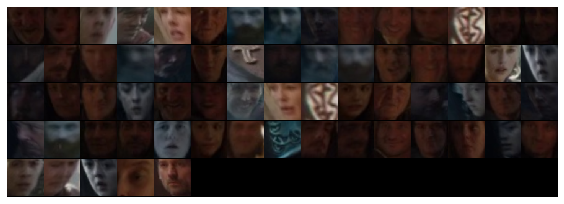

In [65]:
#@title Filter by face size. Threshold is width/height in pixels.
threshold = 37 #@param {type:"number"}

def tooSmall(face, threshold):
  br = face.bbBottomRight
  tl = face.bbTopLeft
  
  height = br[1] - tl[1]
  width = br[0] - tl[0]
  return height < threshold or width < threshold

smallFaces = []
for face in allFaces:
  if tooSmall(face, threshold):
    smallFaces.append(face)
    
print('%d of %d faces get filtered out for being too small.' % (len(smallFaces), len(allFaces)))

showFaces(smallFaces)

Size seems to be a bad filtering metric, so I will ommit from later filtering steps.

86 of 795 faces get filtered out for being too blurry.


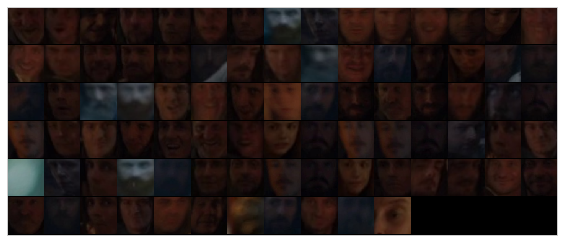

In [12]:
#@title Filter by face blurriness. Threshold is standard deviation of Laplacian.
threshold = 0.006 #@param {type:"number"}

def tooBlurry(face, threshold):
  im = face.image
  im = skimage.color.rgb2gray(im)
  L = scipy.ndimage.filters.laplace(im)
  std = np.std(L)
  
  return std < threshold

blurryFaces = []
for face in allFaces:
  if tooBlurry(face, threshold):
    blurryFaces.append(face)
    
print('%d of %d faces get filtered out for being too blurry.' % (len(blurryFaces), len(allFaces)))

showFaces(blurryFaces)

Characters Tweeted about for following image:
Cersei Lannister	4
Jon Snow	3
Night king	2
Grey Worm	2
Jaime Lannister	2
Tyrion Lannister	2
Brienne of Tarth	1
Samwell Tarly	1
Gendry	1
Daenerys Targaryen	1
Theon Greyjoy	1
the hound	1
Sansa Stark	1


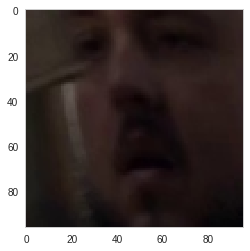

Characters Tweeted about for following image:
Cersei Lannister	4
Jon Snow	3
Night king	2
Grey Worm	2
Jaime Lannister	2
Tyrion Lannister	2
Brienne of Tarth	1
Samwell Tarly	1
Gendry	1
Daenerys Targaryen	1
Theon Greyjoy	1
the hound	1
Sansa Stark	1


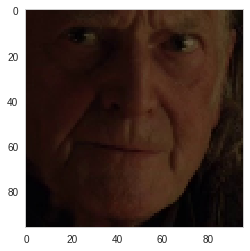

Characters Tweeted about for following image:
Cersei Lannister	4
Jon Snow	3
Night king	2
Grey Worm	2
Jaime Lannister	2
Tyrion Lannister	2
Brienne of Tarth	1
Samwell Tarly	1
Gendry	1
Daenerys Targaryen	1
Theon Greyjoy	1
the hound	1
Sansa Stark	1


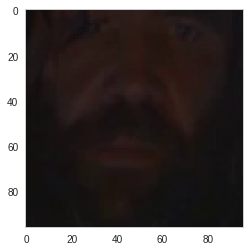

Characters Tweeted about for following image:
Cersei Lannister	4
Jon Snow	3
Night king	2
Grey Worm	2
Jaime Lannister	2
Tyrion Lannister	2
Brienne of Tarth	1
Samwell Tarly	1
Gendry	1
Daenerys Targaryen	1
Theon Greyjoy	1
the hound	1
Sansa Stark	1


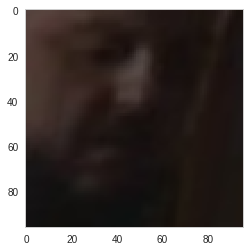

In [29]:
#@title For a random selection of faces, shows which characters were discussed in the specified interval after the face appeared.
minutes = 3 #@param {type:"slider", min:0, max:10, step:1}
numFacesToShow = 4 #@param {type:"slider", min:0, max:10, step:1}
randomSeed = 12345 #@param {type:"integer"}
%matplotlib inline

random.seed(randomSeed)

filteredFaces = list(set(allFaces) - set(blurryFaces) - set(darkFaces))

for idx in range(numFacesToShow):
  face = random.choice(filteredFaces)
  
  faceTime = face.getTime(cutsForEp)
  charactersForFace = utils.charactersAtTimeT(faceTime, charactersForEp, minutes*60.)
  charactersForFace = sorted(charactersForFace, key=lambda x: x[1], reverse=True)
  face.characters = charactersForFace

  print('Characters Tweeted about for following image:')
  for char_count in face.characters:
    print('%s\t%d' % char_count)
  plt.imshow(face.image)
  plt.show()
